In [367]:
import pandas as pd
import numpy as np
import cv2
import zipfile
import os
import matplotlib.pyplot as plt
import tqdm
from PIL import Image
from scipy import sparse
import scipy as sp

In [1]:
pwd

'/mnt/home/icb/alessandro.palma/imCPA/notebooks'

In [23]:
data_dir = '/storage/groups/ml01/workspace/alessandro.palma/dmso'

In [24]:
# Fetch DMSO files 
dmso_ims = pd.read_csv('/home/icb/alessandro.palma/data/metadata/dmso/dmso_ims.csv')[['0','1']]
dmso_ims.columns = ['plate', 'well']

In [25]:
# Get unique plates
plates = np.unique(dmso_ims['plate'].to_numpy())
# Fix names of the stains 
stains = {'Hoechst':{}, 'ERSyto':{}, 'ERSytoBleed':{}, 'Ph_golgi':{}, 'Mito':{}}

In [ ]:
# For the first plates (the one I have images for)
for plate in plates[:16]:  
    # Take the wells with dmso for a certain plate 
    df_plate = dmso_ims[dmso_ims['plate']==plate]
    plate_wells = np.array(df_plate['well'])
    # Foar all the stains
    for stain in stains:
        stains[stain][plate] = {}
        # Get the zip files with the plate and the stain  
        zip_path = os.path.join(data_dir, f"{plate}-{stain}.zip")
        with zipfile.ZipFile(zip_path, "r") as f:
            # Loop over all the files in the zip
            for name in f.namelist():
                if len(name.split('_'))>1 and name.split('_')[1] in plate_wells:
                    well_name = name.split('_')[1]
                    view_name = name.split('_')[2]
                    # Derive a path name
                    if well_name not in stains[stain][plate]:
                        stains[stain][plate][well_name] = {}
                    
                    data = f.open(name)
                    stains[stain][plate][well_name][view_name] = np.array(Image.open(data))

In [42]:
# # Save the results 
# import pickle as pkl
# with open('stains.pkl', 'wb') as f:
#     pkl.dump(stains, f)

In [52]:
# # Load results 
# import pickle as pkl
# with open('stains.pkl', 'rb') as f:
#     stains = pkl.load(f)

In [28]:
golgi = {'Ph_golgi':{}}
# For the first plates (the one I have images for)
for plate in plates[:16]:  
    # Take the wells with dmso for a certain plate 
    df_plate = dmso_ims[dmso_ims['plate']==plate]
    plate_wells = np.array(df_plate['well'])
    # Foar all the stains
    golgi['Ph_golgi'][plate] = {}
    # Get the zip files with the plate and the stain  
    zip_path = os.path.join(data_dir, f"{plate}-{'Ph_golgi'}.zip")
    with zipfile.ZipFile(zip_path, "r") as f:
        # Loop over all the files in the zip
        for name in f.namelist():
            if len(name.split('_'))>2 and name.split('_')[2] in plate_wells:
                well_name = name.split('_')[2]
                view_name = name.split('_')[3]
                # Derive a path name
                if well_name not in golgi['Ph_golgi'][plate]:
                    golgi['Ph_golgi'][plate][well_name] = {}

                data = f.open(name)
                golgi['Ph_golgi'][plate][well_name][view_name] = np.array(Image.open(data))

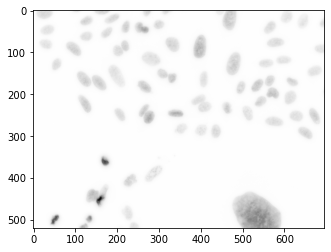

In [38]:
# plt.imshow(stains['Hoechst'][24280]['l23']['s4'], cmap='Greys')
# plt.imshow(golgi['Ph_golgi'][24280]['l23']['s4'], cmap='Greys')

## Destination images 

In [ ]:
# Order Mito --> Ph_golgi --> ERSytoBleed --> ERSyto --> Hoechst 

In [99]:
def quantize16_to_8(im):
    """
    Convert a 16-bit numpy array into an 8-bit one
    """
    ratio = np.amax(im) / 256
    im = (im/ratio).astype('uint8')
    return im

In [147]:
c = 0

final_images = {}

# For each plate in any of the channels (should correspond)
for plate in stains['Mito']:
    final_images[plate] = {}
    for well in stains['Mito'][plate]:
        final_images[plate][well] = {}
        for view in stains['Mito'][plate][well]: 
            # Fetch image 
            img_mito = stains['Mito'][plate][well][view]
            img_er = stains['ERSyto'][plate][well][view]
            img_rna = stains['ERSytoBleed'][plate][well][view]
            img_golgi = stains['Ph_golgi'][plate][well][view]
            img_nuclei = stains['Hoechst'][plate][well][view]
            # Normalize images 
            img_mito = quantize16_to_8(img_mito[:,:,np.newaxis])
            img_er = quantize16_to_8(img_er[:,:,np.newaxis])
            img_rna = quantize16_to_8(img_rna[:,:,np.newaxis])
            img_golgi = quantize16_to_8(img_golgi[:,:,np.newaxis])
            img_nuclei = quantize16_to_8(img_nuclei[:,:,np.newaxis])      
            # Image 
            img = np.stack([img_mito, img_er, img_rna, img_golgi, img_nuclei], axis=2)  
            final_images[plate][well][view] = np.squeeze(img)

In [ ]:
# Check how many images 
for plate in final_images:
    for well in final_images[plate]:
        for view in final_images[plate][well]:
            plotter.plot_channel_panel(final_images[plate][well][view], 0, False, True, title = f'Example DMSO number {c}')
        break
    break

In [149]:
# Check how many images 
c = 0
for plate in final_images:
    for well in final_images[plate]:
        for view in final_images[plate][well]:
            c += 1
            
print(f'Collected {c} images of DMSO')

Collected 6168 images of DMSO


# SAVE THE IMAGE DATA

In [158]:
destination_folder = '/storage/groups/ml01/workspace/alessandro.palma/cellpainting_512_dmso' 
channels = np.array({'0': 'Mito', '1': 'ERSyto', '2': 'ERSytoBleed', '3': 'Ph_golgi', '4': 'Hoechst'})

In [162]:
res = np.load('/storage/groups/ml01/workspace/alessandro.palma/cellpainting_512/25590-I21-5.npz')
res['sample'].shape

(520, 696, 5)

In [168]:
# Dump the images into numpy files 
for plate in final_images:
    for well in final_images[plate]:
        for view in final_images[plate][well]:
            filename = f'{plate}-{well.upper()}-{view[1]}'
            image = final_images[plate][well][view]
            np.savez(os.path.join(destination_folder, filename), sample=image, channels=channels)

## Create the csv file for the DMSOs

In [317]:
columns = ['SAMPLE_KEY', 'BROAD_ID', 'PLATE_ID', 'WELL_POSITION', 'SITE', 'SAMPLE_ID', 'CPD_NAME', 'CPD_NAME_TYPE', 'SMILES', 'STATE', 'ROW_NR_LABEL_MAT']
dmso_data_frame = []
smile_dmso = 'CS(=O)C'

In [318]:
# Get the dataframe for the dmso
for plate in final_images:
    for well in final_images[plate]:
        for view in final_images[plate][well]:
            # Extract from the 
            SAMPLE_KEY = f'{plate}-{well.upper()}-{view[1]}'
            BROAD_ID = '-' 
            PLATE_ID = plate
            WELL_POSITION = well
            SITE = view[1] 
            SAMPLE_ID = '-'
            CPD_NAME = 'DMSO'
            CPD_NAME_TYPE = 'solvent control'
            SMILES = smile_dmso
            STATE = 'ctr'
            ROW_NR_LABEL_MAT = 0
            dmso_data_frame.append([SAMPLE_KEY, BROAD_ID, PLATE_ID, WELL_POSITION, SITE, SAMPLE_ID, CPD_NAME, CPD_NAME_TYPE, SMILES, STATE, ROW_NR_LABEL_MAT])

In [319]:
dmso_data_frame = pd.DataFrame(dmso_data_frame)
dmso_data_frame.columns = columns

In [320]:
# Read the general data 
file_train = pd.read_csv('/home/icb/alessandro.palma/data/metadata/original_data/splits/datasplit1-train.csv')
file_test = pd.read_csv('/home/icb/alessandro.palma/data/metadata/original_data/splits/datasplit1-test.csv')
file_val = pd.read_csv('/home/icb/alessandro.palma/data/metadata/original_data/splits/datasplit1-val.csv')

original_data = pd.concat([file_train, file_test, file_val], ignore_index = True)
original_data['STATE'] = 'trt' 

In [321]:
#total_data = pd.concat([file_train, file_test, file_val, dmso_data_frame])
original_data = original_data[columns]
# Increase by one because the first row is going to be the DMSO 
original_data.ROW_NR_LABEL_MAT = np.array(original_data.ROW_NR_LABEL_MAT) + 1

In [322]:
total_data = pd.concat([original_data, dmso_data_frame], ignore_index = True)

In [323]:
total_data

,SAMPLE_KEY,BROAD_ID,PLATE_ID,WELL_POSITION,SITE,SAMPLE_ID,CPD_NAME,CPD_NAME_TYPE,SMILES,STATE,ROW_NR_LABEL_MAT
0,24277-A03-1,BRD-K18438502-001-02-6,24277,A03,1,SA58078,pinosylvin methyl ether,primary-common,COc1cc(O)cc(\C=C\c2ccccc2)c1,trt,943
1,24277-A03-2,BRD-K18438502-001-02-6,24277,A03,2,SA58078,pinosylvin methyl ether,primary-common,COc1cc(O)cc(\C=C\c2ccccc2)c1,trt,943
2,24277-A03-3,BRD-K18438502-001-02-6,24277,A03,3,SA58078,pinosylvin methyl ether,primary-common,COc1cc(O)cc(\C=C\c2ccccc2)c1,trt,943
3,24277-A03-4,BRD-K18438502-001-02-6,24277,A03,4,SA58078,pinosylvin methyl ether,primary-common,COc1cc(O)cc(\C=C\c2ccccc2)c1,trt,943
4,24277-A03-5,BRD-K18438502-001-02-6,24277,A03,5,SA58078,pinosylvin methyl ether,primary-common,COc1cc(O)cc(\C=C\c2ccccc2)c1,trt,943
...,...,...,...,...,...,...,...,...,...,...,...
290197,24307-C16-2,-,24307,c16,2,-,DMSO,solvent control,CS(=O)C,ctr,0
290198,24307-C16-4,-,24307,c16,4,-,DMSO,solvent control,CS(=O)C,ctr,0
290199,24307-C16-5,-,24307,c16,5,-,DMSO,solvent control,CS(=O)C,ctr,0
290200,24307-C16-3,-,24307,c16,3,-,DMSO,solvent control,CS(=O)C,ctr,0


In [324]:
total_data.to_csv('/home/icb/alessandro.palma/data/metadata/integrated_data/splits/total_dataset.csv')

## Process the label matrix 

In [353]:
# Get the label matrix
from scipy.io import mmread
label_mat = mmread('/home/icb/alessandro.palma/data/metadata/integrated_data/label_matrix/label-matrix.mtx')

In [356]:
label_mat_dense = label_mat.todense()
len(label_mat_dense)

10574

In [357]:
dmso_row = -1*np.ones(label_mat_dense.shape[1])

In [358]:
label_mat_dense = np.vstack([dmso_row, label_mat_dense])

In [360]:
label_mat_dense.shape

(10575, 209)

In [363]:
label_mat_extended = sparse.coo_matrix(label_mat_dense)

In [ ]:
sp.io.mmwrite('/home/icb/alessandro.palma/data/metadata/integrated_data/label_matrix/label-matrix.mtx', label_mat_extended)